<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC1_Turbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# %pip install sktime tsfresh;
%pip install sktime tsfresh;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [3]:
import sktime

In [160]:
# Enable HalvingSearch
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

In [4]:
sns.set_palette('colorblind')

# Dataset Download

In [5]:
!git clone https://github.com/arthursl12/dataset_2
!mv /content/dataset_2/CMaps /content/CMaps
!rm -rf dataset_2

Cloning into 'dataset_2'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [6]:
folder='/content/CMaps/'

# Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [7]:
# Column names
index_cols = ['unit_number', 'time']
settings_cols = ['op_1', 'op_2', 'op_3']
sensors_cols = [f's_{i}'for i in range(21)]
cols = index_cols + settings_cols + sensors_cols

In [8]:
train = pd.read_csv((folder+'train_FD001.txt'), sep='\s+', header=None, names=cols)
test = pd.read_csv((folder+'test_FD001.txt'), sep='\s+', header=None, names=cols)
y_test = pd.read_csv((folder+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [9]:
train

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Data Processing

## Extract Features

In [31]:
def extract_basic_features(df=train, unit_col='unit_number'):
    # Extract mean, std, min and max from each sample's 20 sensor time series
    sensors_mean = df[[unit_col]+sensors_cols].groupby(unit_col).mean()
    sensors_mean = sensors_mean.add_suffix('_mean')
    sensors_std = df[[unit_col]+sensors_cols].groupby(unit_col).std()
    sensors_std = sensors_std.add_suffix('_std')
    sensors_min = df[[unit_col]+sensors_cols].groupby(unit_col).min()
    sensors_min = sensors_min.add_suffix('_min')
    sensors_max = df[[unit_col]+sensors_cols].groupby(unit_col).max()
    sensors_max = sensors_max.add_suffix('_max')

    return sensors_mean.join([sensors_std, sensors_min, sensors_max])

In [32]:
extracted_df = extract_basic_features()
extracted_df.head()

,s_0_mean,s_1_mean,s_2_mean,s_3_mean,s_4_mean,s_5_mean,s_6_mean,s_7_mean,s_8_mean,s_9_mean,...,s_11_max,s_12_max,s_13_max,s_14_max,s_15_max,s_16_max,s_17_max,s_18_max,s_19_max,s_20_max
unit_number,,,,,,,,,,,,,,,,,,,,,
1,518.67,642.621042,1589.485521,1407.262135,14.62,21.610000,553.439427,2388.110260,9048.265833,1.3,...,522.86,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999
2,518.67,642.435226,1588.181986,1404.265854,14.62,21.609338,553.853484,2388.057213,9062.652439,1.3,...,523.26,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005
3,518.67,642.543743,1588.715084,1405.628994,14.62,21.609777,553.800056,2388.049777,9081.265866,1.3,...,523.18,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181
4,518.67,642.662381,1590.563280,1408.253915,14.62,21.609947,553.443016,2388.079101,9077.366825,1.3,...,522.48,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074
5,518.67,642.451970,1588.153271,1404.878439,14.62,21.609331,553.882342,2388.034201,9083.948253,1.3,...,523.04,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503


## Test Set 
Test set has samples for all cycles, but has annotations only for last one

In [35]:
test

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [36]:
y_test.count()

RUL    100
dtype: int64

In [37]:
# Let's take only the last line for each test set
test1 = test.groupby('unit_number').last().reset_index()
test1

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,...,522.30,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606
96,97,134,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,...,521.58,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953
97,98,121,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,...,521.53,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608
98,99,97,0.0047,-0.0000,100.0,518.67,642.00,1585.03,1397.98,14.62,...,521.82,2388.02,8150.38,8.4003,0.03,391,2388,100.0,38.95,23.3595


## Remaining Useful Life (RUL)

In [38]:
# RUL: how many cycles remain ? 
#   Take the last (maximun) cycle registered ('time' column) for that sample
#   Subtract from current cycle number
#   i.e. assume linear RUL decay
def add_remaining_useful_life_linear(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

,unit_number,time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [67]:
def compute_remaining_useful_life_only_last(df=train, unit_col='unit_number'):
    grouped_by_unit = df.groupby(by=unit_col)
    max_cycle = grouped_by_unit["time"].max()
    return max_cycle

In [69]:
compute_remaining_useful_life_only_last().head()

unit_number
1    192
2    287
3    179
4    189
5    269
Name: time, dtype: int64

# EDA

In [ ]:
train[index_cols].groupby('unit_number').count().transpose()

unit_number,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
time,192,287,179,189,269,188,259,150,201,222,...,135,341,155,258,283,336,202,156,185,200


Cada amostra tem um tempo de término diferente, exatamente pois cada uma falhou em um tempo diferente

In [40]:
train[settings_cols].describe()

,op_1,op_2,op_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


No cenário FD001 só há uma condição, então é esperado que não haja muita variação nessas configurações.

In [41]:
train[sensors_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_0,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_1,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_2,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_3,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_4,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_5,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_6,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_7,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_8,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_9,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


Alguns sensores são constantes para esse cenário, eles não trarão informação para o modelo.

In [42]:
def sample_list_index(n_frac, df=train, unit_col='unit_number'):
    numbers = pd.DataFrame(df.groupby(unit_col).nunique().index)
    n = round(n_frac * len(numbers))
    numbers_sample = numbers.sample()[unit_col]
    nums = list(numbers.sample(n, random_state=42)[unit_col])
    return nums
sample_list_index(0.2)

[84, 54, 71, 46, 45, 40, 23, 81, 11, 1, 19, 31, 74, 34, 91, 5, 77, 78, 13, 32]

In [43]:
def plot_sensor_i(i,df=train,n_frac=0.1,unit_col='unit_number',time_col='time'):
    sensor_col = f's_{i}'
    indexes = sample_list_index(n_frac)
    plt.title(f"Sensor {i}")
    for k in indexes:
        df1 = df[df[unit_col] == k][[time_col,sensor_col]]
        df1 = df1.set_index(time_col)
        plt.plot(df1)

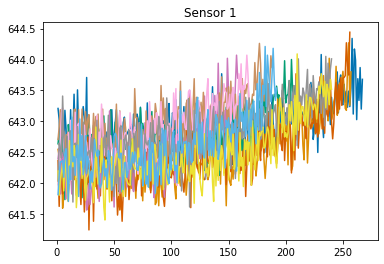

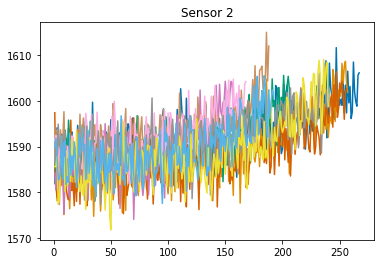

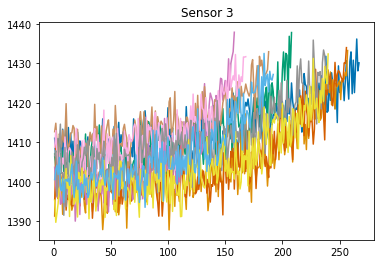

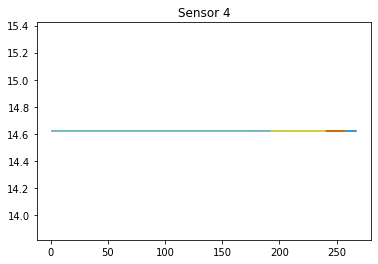

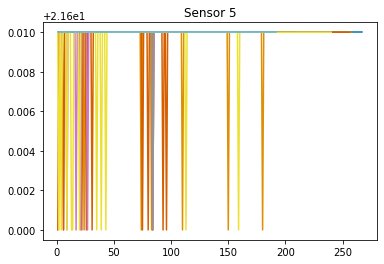

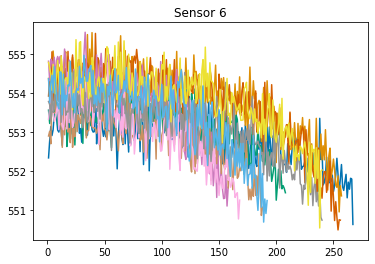

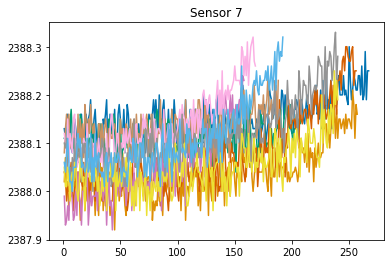

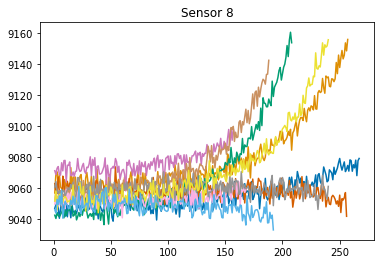

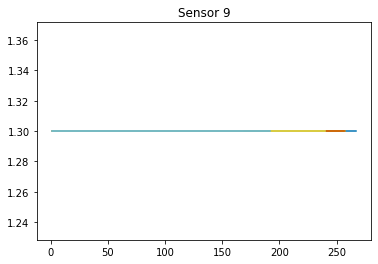

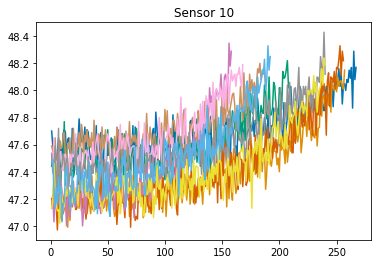

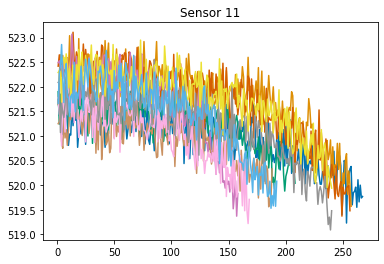

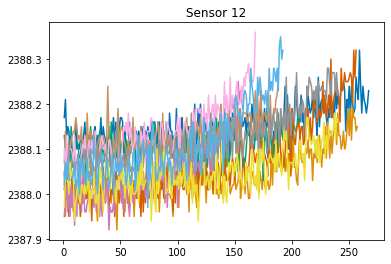

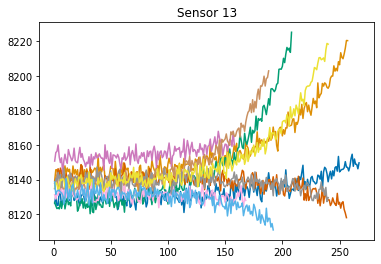

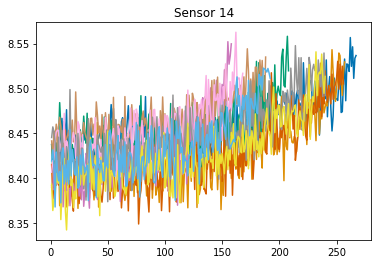

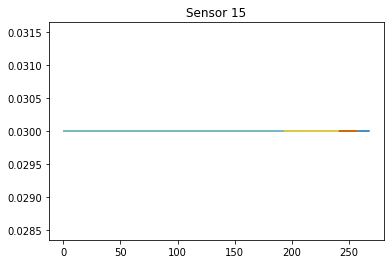

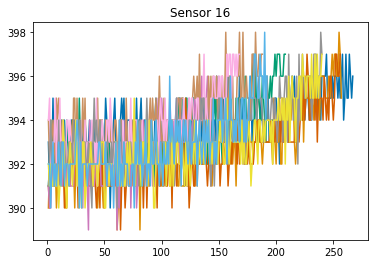

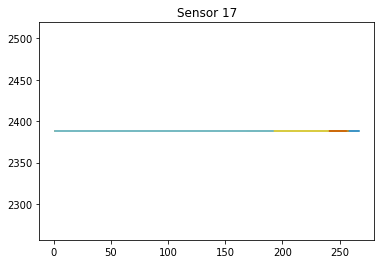

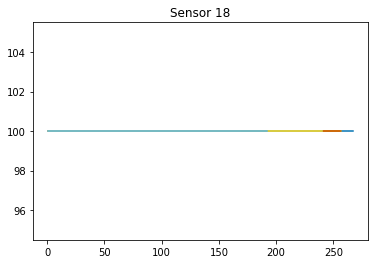

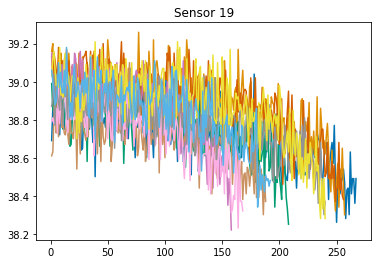

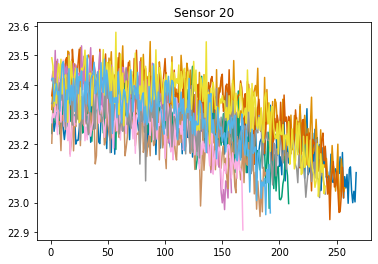

In [44]:
for i in range(1,21):
    plot_sensor_i(i)
    plt.show()

# LinearRegression

In [142]:
y_train = train['RUL']
y_train.head()

0    191
1    190
2    189
3    188
4    187
Name: RUL, dtype: int64

In [143]:
X_train = train
X_train = X_train.drop(index_cols+settings_cols+['RUL'], axis=1)
X_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [149]:
from sklearn.metrics import mean_squared_error, r2_score

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_pred, y_true)
    return np.sqrt(mse)

def show_result(y_true, y_pred):
    print(f"R2={r2_score(y_true, y_pred):.3f}, RMSE={rmse(y_true, y_pred):.3f}")

In [151]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
show_result(y_train, model.predict(X_train))

R2=0.580, RMSE=44.663


## Non-linear decay

In [152]:
y_non_linear = y_train.clip(upper=50)
y_non_linear.head()

0    50
1    50
2    50
3    50
4    50
Name: RUL, dtype: int64

In [154]:
k = 50
y_non_linear = y_train.clip(upper=k)
model = LinearRegression()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))

R2=0.675, RMSE=7.428


In [170]:
from sklearn.model_selection import cross_val_score

myrange = np.arange(50,150,10)
for k in myrange:
    y_non_linear = y_train.clip(upper=k)
    model = LinearRegression()
    model.fit(X_train, y_non_linear)
    # show_result(y_non_linear, model.predict(X_train))
    score_mean = cross_val_score(model, X_train, y_non_linear, cv=5, scoring='r2').mean()
    print(f"{k}: {score_mean:.3f}")

50: 0.670
60: 0.710
70: 0.735
80: 0.748
90: 0.753
100: 0.752
110: 0.745
120: 0.736
130: 0.724
140: 0.710


In [166]:
myrange = np.arange(80,110,5)

for k in myrange:
    y_non_linear = y_train.clip(upper=k)
    model = LinearRegression()
    model.fit(X_train, y_non_linear)
    # show_result(y_non_linear, model.predict(X_train))
    score_mean = cross_val_score(model, X_train, y_non_linear, cv=5, scoring='r2').mean()
    print(f"Score Mean (CV)={score_mean:.3f}")

Score Mean (CV)=0.748
Score Mean (CV)=0.752
Score Mean (CV)=0.753
Score Mean (CV)=0.753
Score Mean (CV)=0.752
Score Mean (CV)=0.749


In [158]:
k = 90
y_non_linear = y_train.clip(upper=k)
model = LinearRegression()
model.fit(X_train, y_non_linear)
show_result(y_non_linear, model.predict(X_train))

R2=0.758, RMSE=13.959


# Linear Regressor (features)

## Linear Regressor

In [64]:
X_train = extracted_df
X_train.head()

,s_0_mean,s_1_mean,s_2_mean,s_3_mean,s_4_mean,s_5_mean,s_6_mean,s_7_mean,s_8_mean,s_9_mean,...,s_11_max,s_12_max,s_13_max,s_14_max,s_15_max,s_16_max,s_17_max,s_18_max,s_19_max,s_20_max
unit_number,,,,,,,,,,,,,,,,,,,,,
1,518.67,642.621042,1589.485521,1407.262135,14.62,21.610000,553.439427,2388.110260,9048.265833,1.3,...,522.86,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999
2,518.67,642.435226,1588.181986,1404.265854,14.62,21.609338,553.853484,2388.057213,9062.652439,1.3,...,523.26,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005
3,518.67,642.543743,1588.715084,1405.628994,14.62,21.609777,553.800056,2388.049777,9081.265866,1.3,...,523.18,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181
4,518.67,642.662381,1590.563280,1408.253915,14.62,21.609947,553.443016,2388.079101,9077.366825,1.3,...,522.48,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074
5,518.67,642.451970,1588.153271,1404.878439,14.62,21.609331,553.882342,2388.034201,9083.948253,1.3,...,523.04,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503


In [72]:
y_train = compute_remaining_useful_life_only_last()
y_train.head()

unit_number
1    192
2    287
3    179
4    189
5    269
Name: time, dtype: int64

In [85]:
model = LinearRegression()
model.fit(X_train, y_train)
show_result(y_train, model.predict(X_train))

R2=0.808, RMSE=20.226


## Ridge

In [95]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.head()

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.0,-0.381719,-0.586009,-0.496753,1.776357e-15,0.781439,0.233117,0.279478,-1.301776,-2.220446e-16,...,0.635116,0.889042,-0.896812,-1.926422,0.0,0.616847,0.0,0.0,0.133822,0.027617
1,0.0,-1.403405,-1.267667,-1.306962,1.776357e-15,-2.019321,1.301930,-1.017293,-0.165378,-2.220446e-16,...,1.587314,-0.343836,-0.090167,-0.761154,0.0,0.616847,0.0,0.0,0.791966,1.780447
2,0.0,-0.806738,-0.988894,-0.938362,1.776357e-15,-0.163951,1.164015,-1.199069,1.304897,-2.220446e-16,...,1.396875,-1.165755,1.748817,-0.869912,0.0,2.085531,0.0,0.0,0.682275,0.344729
3,0.0,-0.154420,-0.022416,-0.228571,1.776357e-15,0.557597,0.242381,-0.482235,0.996912,-2.220446e-16,...,-0.269472,-1.576714,1.842876,-0.100835,0.0,2.085531,0.0,0.0,0.462894,0.158295
4,0.0,-1.311341,-1.282683,-1.141316,1.776357e-15,-2.049461,1.376421,-1.579824,1.516779,-2.220446e-16,...,1.063605,-0.754795,0.823216,-0.504794,0.0,0.616847,0.0,0.0,1.340418,0.905774


In [128]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.1, fit_intercept=True, solver='auto')
model.fit(X_train_sc, y_train)
show_result(y_train, model.predict(X_train_sc))

R2=0.786, RMSE=21.338


In [129]:
show_result(y_test, model.predict(X_test_sc))

R2=-6.284, RMSE=112.154


In [138]:
from sklearn.model_selection import GridSearchCV

param_distributions = [{"alpha": [0.001,0.01,0.1,1,10,50,100,200,1000],
                       "fit_intercept": [True,False],
                       "solver": ['svd', 'cholesky', 'saga'],
                       "max_iter":[1e3,1e4,1e5,1e6]
                       },
                       {"alpha": [0.001,0.01,0.1,1,10,50,100,200,1000],
                       "fit_intercept": [True,False],
                       "solver": ['lsqr', 'sparse_cg', 'sag'],
                       "max_iter":[None,1e3,1e4,1e5,1e6,1e7,1e8]
                       }]

search = GridSearchCV(model, param_distributions, scoring='r2')
search.fit(X_train_sc, y_train)
search.best_params_  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


{'alpha': 100, 'fit_intercept': True, 'max_iter': 1000000.0, 'solver': 'sag'}

In [139]:
model = Ridge(alpha=100, fit_intercept=True,max_iter=1000000, solver='sag')
model.fit(X_train_sc, y_train)
show_result(y_train, model.predict(X_train_sc))

R2=0.325, RMSE=37.897


In [140]:
extracted_test = extract_basic_features(df=test)
X_test_sc = sc.transform(extracted_test)
X_test_sc.shape

(100, 84)

In [141]:
show_result(y_test, model.predict(X_test_sc))

R2=-3.565, RMSE=88.791


# OFF

In [33]:
# Proposital error to stop here
if (a[-2])

SyntaxError: ignored

In [ ]:
idx = 1
sensors_idx_df = train[train['unit_number'] == idx][sensors_cols]
mean_df = sensors_idx_df.mean(axis=0)
mean_df.index = [old_name+'_mean' for old_name in mean_df.index]
mean_df

s_0_mean      518.670000
s_1_mean      642.621042
s_2_mean     1589.485521
s_3_mean     1407.262135
s_4_mean       14.620000
s_5_mean       21.610000
s_6_mean      553.439427
s_7_mean     2388.110260
s_8_mean     9048.265833
s_9_mean        1.300000
s_10_mean      47.514063
s_11_mean     521.459427
s_12_mean    2388.110833
s_13_mean    8128.913542
s_14_mean       8.436555
s_15_mean       0.030000
s_16_mean     392.854167
s_17_mean    2388.000000
s_18_mean     100.000000
s_19_mean      38.840052
s_20_mean      23.306310
dtype: float64

In [ ]:
idx = 2
sensors_idx_df = train[train['unit_number'] == idx][sensors_cols]
mean_df2 = sensors_idx_df.mean(axis=0)
mean_df2.index = [old_name+'_mean' for old_name in mean_df2.index]
mean_df2

s_0_mean      518.670000
s_1_mean      642.435226
s_2_mean     1588.181986
s_3_mean     1404.265854
s_4_mean       14.620000
s_5_mean       21.609338
s_6_mean      553.853484
s_7_mean     2388.057213
s_8_mean     9062.652439
s_9_mean        1.300000
s_10_mean      47.389512
s_11_mean     521.811603
s_12_mean    2388.053554
s_13_mean    8143.246167
s_14_mean       8.423983
s_15_mean       0.030000
s_16_mean     392.386760
s_17_mean    2388.000000
s_18_mean     100.000000
s_19_mean      38.901150
s_20_mean      23.338997
dtype: float64

In [ ]:
tmp_df = mean_df.to_frame()
tmp_df

,0
s_0_mean,518.670000
s_1_mean,642.621042
s_2_mean,1589.485521
s_3_mean,1407.262135
s_4_mean,14.620000
s_5_mean,21.610000
s_6_mean,553.439427
s_7_mean,2388.110260
s_8_mean,9048.265833
s_9_mean,1.300000


In [ ]:
mean_df = sensors_idx_df.mean(axis=0)
mean_df.index

Index(['s_0', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9',
       's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18',
       's_19', 's_20'],
      dtype='object')

In [ ]:
[old_name+'_mean' for old_name in mean_df.index]

AttributeError: ignored

In [ ]:
sensors_idx_df = sensors_idx_df.reset_index(drop=True)
sensors_idx_df

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,641.89,1583.84,1391.28,14.62,21.60,554.53,2388.01,9054.72,1.3,...,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585
1,518.67,641.82,1587.05,1393.13,14.62,21.61,554.77,2387.98,9051.31,1.3,...,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085
2,518.67,641.55,1588.32,1398.96,14.62,21.60,555.14,2388.04,9054.24,1.3,...,522.58,2387.99,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250
3,518.67,641.68,1584.15,1396.08,14.62,21.61,554.25,2387.98,9058.01,1.3,...,522.49,2387.93,8140.44,8.4018,0.03,391,2388,100.0,39.13,23.5027
4,518.67,641.73,1579.03,1402.52,14.62,21.60,555.12,2388.03,9058.15,1.3,...,522.27,2387.94,8136.67,8.3867,0.03,390,2388,100.0,39.18,23.4234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,518.67,643.78,1602.03,1429.67,14.62,21.61,551.46,2388.16,9084.13,1.3,...,520.07,2388.20,8174.85,8.5199,0.03,398,2388,100.0,38.42,23.0358
283,518.67,643.91,1601.35,1430.04,14.62,21.61,551.96,2388.22,9089.87,1.3,...,519.95,2388.21,8166.83,8.5291,0.03,395,2388,100.0,38.23,23.1196
284,518.67,643.67,1596.84,1431.17,14.62,21.61,550.85,2388.20,9098.67,1.3,...,519.91,2388.22,8164.83,8.5242,0.03,396,2388,100.0,38.39,23.1155
285,518.67,643.44,1603.63,1429.57,14.62,21.61,551.61,2388.18,9102.01,1.3,...,519.51,2388.22,8169.97,8.4932,0.03,395,2388,100.0,38.33,23.0169


In [ ]:
def extract()

In [ ]:
tup = sensors_idx_df[ssr].transpose().mean(), sensors_idx_df[ssr].std(), sensors_idx_df[ssr].min(), sensors_idx_df[ssr].max()
extracted_df.iloc[1] = tup
extracted_df

IndexError: ignored

In [ ]:
np.array(sensors_idx_df[ssr]).mean()

518.67

In [ ]:
ssr = sensors_cols[0]
extracted_df[ssr+"_mean"] = sensors_idx_df.mean(axis=0)[ssr]
extracted_df[ssr+"_std"] = sensors_idx_df[ssr].std()
extracted_df[ssr+"_min"] = sensors_idx_df[ssr].min()
extracted_df[ssr+"_max"] = sensors_idx_df[ssr].max()
extracted_df

,s_0_mean,s_0_std,s_0_min,s_0_max,s_0_1mean


In [ ]:
sensors_idx_df[ssr].mean()

518.6699999999986

In [ ]:
last = 100
unit_col = 'unit_number'
sensors_cols = sensors_cols

extracted_df = pd.DataFrame()
for idx in range(1,3):
    # print(idx)
    sensors_idx_df = train[train[unit_col] == idx][sensors_cols]
    # print(sensors_idx_df)
    for ssr in sensors_cols[:1]:
        extracted_df[ssr+"_mean"] = np.array(sensors_idx_df[ssr]).mean()
        # extracted_df[ssr+"_std"] = sensors_idx_df[ssr].std()
        # extracted_df[ssr+"_min"] = sensors_idx_df[ssr].min()
        # extracted_df[ssr+"_max"] = sensors_idx_df[ssr].max()
        print(extracted_df)
extracted_df['s_0_mean']

Empty DataFrame
Columns: [s_0_mean]
Index: []
Empty DataFrame
Columns: [s_0_mean]
Index: []


Series([], Name: s_0_mean, dtype: float64)

# Feature Extraction